<a href="https://colab.research.google.com/github/savya08/Modified-MNIST/blob/master/CS445_Proj2_Starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2020


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [86]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import heapq

datadir = "/content/drive/MyDrive/CS 445: Computational Photography/Assignment 2/" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

In [3]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

In [4]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray    The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """

    # create `out` as a placeholder for the output
    out = np.zeros((out_size, out_size, 3), dtype='uint8')

    for i in range(out_size // patch_size + 1):
        for j in range(out_size // patch_size + 1):
            # randomly select patches from `sample`
            x = np.random.choice(sample.shape[0] - patch_size)
            y = np.random.choice(sample.shape[1] - patch_size)
            patch = sample[x : (x + patch_size), y : (y + patch_size), :]

            # place the patch in `out`
            out[i * patch_size : min((i + 1) * patch_size, out.shape[0]), 
                j * patch_size : min((j + 1) * patch_size, out.shape[1]), 
                :] = patch[0 : min(patch_size, out.shape[0] - i * patch_size),
                           0 : min(patch_size, out.shape[1] - j * patch_size),
                           :]

    return out

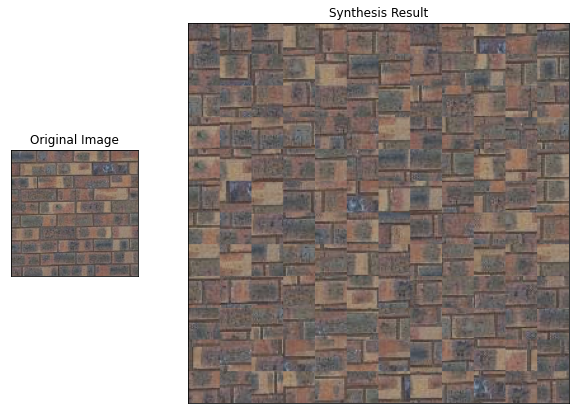

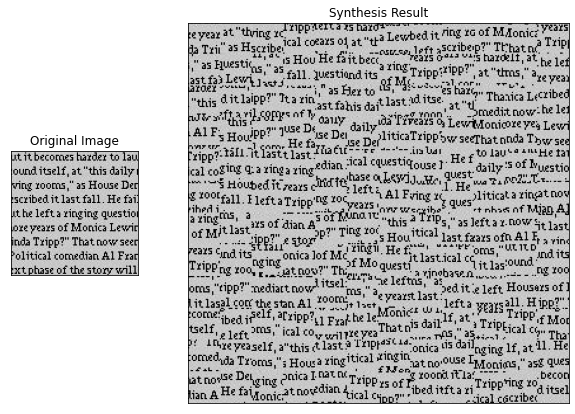

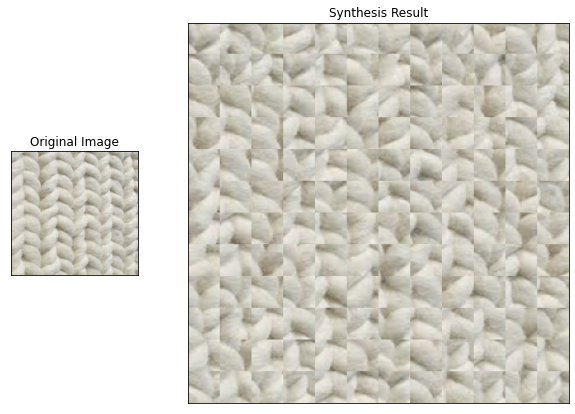

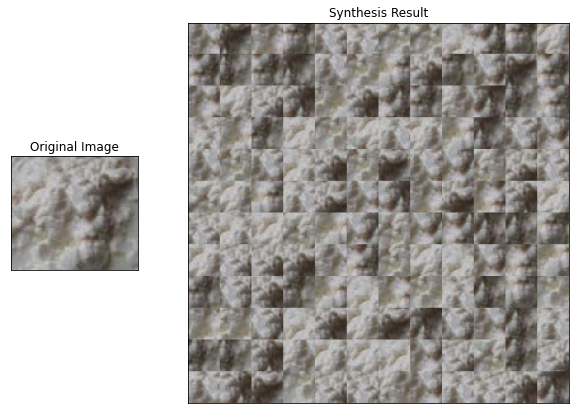

In [5]:
imgs = ['bricks_small.jpg', 'text_small.jpg', 'texture.png', 'white_small.jpg']

for img_name in imgs:
    sample_img_fn = 'samples/{}'.format(img_name)
    sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)

    out_size = 300
    patch_size = 25
    res = quilt_random(sample_img, out_size, patch_size)
    if res is not None:
        fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 3]}, figsize=(10, 10))
        axes[0].imshow(sample_img)
        axes[0].set_title('Original Image'), axes[0].set_xticks([]), axes[0].set_yticks([])
        axes[1].imshow(res)
        axes[1].set_title('Synthesis Result'), axes[1].set_xticks([]), axes[1].set_yticks([])

### Part II: Overlapping Patches (30 pts)

In [6]:
def ssd_patch(template, mask, sample):
    ssd_cost = None
    for i in range(3):
        T = template[:, :, i]
        M = mask[:, :, i]
        I = sample[:, :, i]
        channel_ssd_cost = ((M * T) ** 2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel=M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
        if i == 0: ssd_cost = channel_ssd_cost
        else: ssd_cost += channel_ssd_cost
    return ssd_cost

In [7]:
def choose_sample(sample, ssd_cost, tol, patch_size):
    samples = []
    half_width = patch_size // 2
    for i in range(half_width, ssd_cost.shape[0] - half_width):
        for j in range(half_width, ssd_cost.shape[1] - half_width):
            samples.append((ssd_cost[i][j], i, j))
    samples.sort()
    index = np.random.choice(np.arange(tol))
    xc, yc = samples[index][1], samples[index][2]
    return sample[(xc - half_width) : (xc + half_width + 1),
                  (yc - half_width) : (yc + half_width + 1),
                  :]

In [8]:
def quilt_simple(sample, out_size, patch_size, overlap, tol, random_first_patch=False):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """

    # normalize the `sample` image
    sample = sample / 255.

    # create `out` as a placeholder for the output
    out = np.zeros((out_size, out_size, 3))

    for i in range((out_size - patch_size) // (patch_size - overlap) + 2):
        for j in range((out_size - patch_size) // (patch_size - overlap) + 2):
            # fill in the top-left of `out` with a random patch from `sample`
            if i == 0 and j == 0:
                if random_first_patch:
                    # randomly select a patch from `sample`
                    x = np.random.choice(sample.shape[0] - patch_size)
                    y = np.random.choice(sample.shape[1] - patch_size)
                    patch = sample[x : (x + patch_size), y : (y + patch_size), :]
                else:
                    # select the upper-left patch from `sample` as the first patch
                    patch = sample[0 : patch_size, 0 : patch_size, :]

                # place the patch in `out`
                out[0 : patch_size, 0 : patch_size, :] = patch
            
            # find a good patch for overlapping cases
            else:
                # find a patch with low cost
                ## get the template from `out`
                template = out[(i * patch_size - i * overlap) : ((i + 1) * patch_size - i * overlap), 
                               (j * patch_size - j * overlap) : ((j + 1) * patch_size - j * overlap), 
                               :]
                ## create the mask
                mask = np.zeros(template.shape)
                if i != 0: mask[0 : overlap, :, :] = 1.
                if j != 0: mask[:, 0 : overlap, :] = 1.
                
                ## find the `ssd_cost` patch
                ssd_cost = ssd_patch(template, mask, sample)

                # choose a patch with low cost
                patch = choose_sample(sample, ssd_cost, tol, patch_size)

                # place the patch in `out`
                out[(i * patch_size - i * overlap) : min(out.shape[0], ((i + 1) * patch_size - i * overlap)), 
                    (j * patch_size - j * overlap) : min(out.shape[1], ((j + 1) * patch_size - j * overlap)), 
                    :] = patch[0 : min(patch_size, out.shape[0] - (i * patch_size - i * overlap)),
                               0 : min(patch_size, out.shape[1] - (j * patch_size - j * overlap)),
                               :]
    
    return out

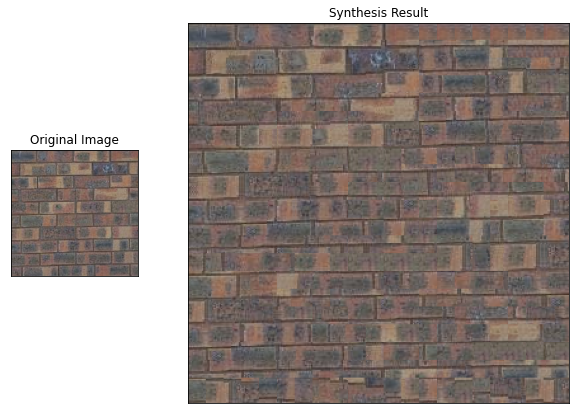

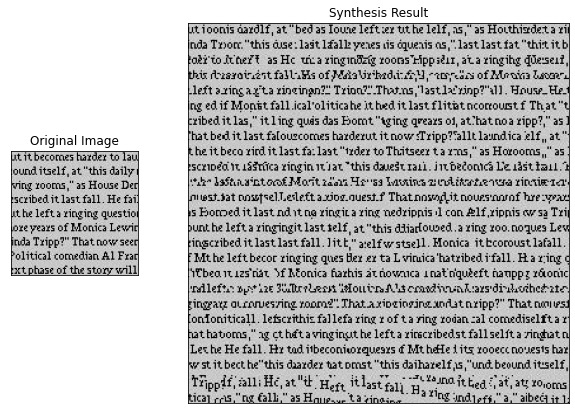

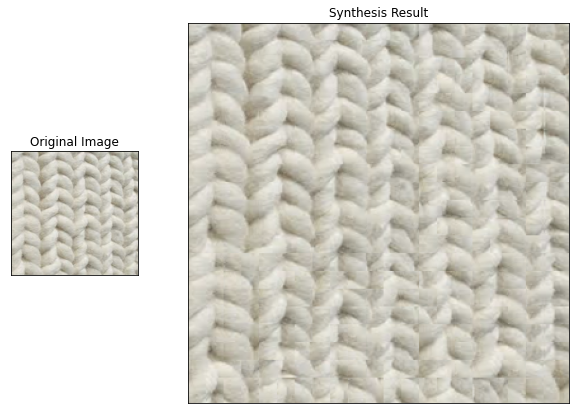

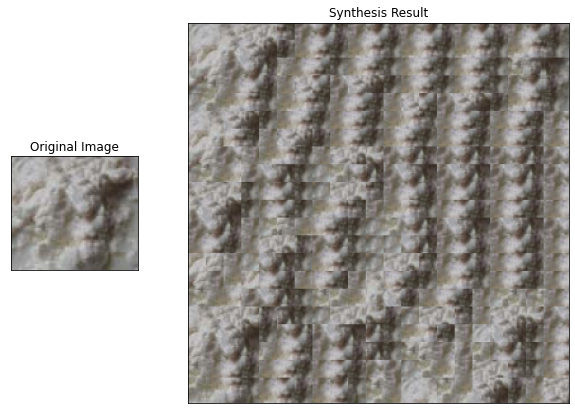

In [74]:
imgs = ['bricks_small.jpg', 'text_small.jpg', 'texture.png', 'white_small.jpg']

for img_name in imgs:
    sample_img_fn = 'samples/{}'.format(img_name)
    sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)

    out_size = 300
    patch_size = 25
    overlap = 11
    tol = 3
    res = quilt_simple(sample_img, out_size, patch_size, overlap, tol)
    if res is not None:
        fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 3]}, figsize=(10, 10))
        axes[0].imshow(sample_img)
        axes[0].set_title('Original Image'), axes[0].set_xticks([]), axes[0].set_yticks([])
        axes[1].imshow(res)
        axes[1].set_title('Synthesis Result'), axes[1].set_xticks([]), axes[1].set_yticks([])

### Part III: Seam Finding (20 pts)


In [9]:
def customized_cut(bndcost):
    class Node:
        ''' A class to represent the pixel nodes in the error patch '''
        def __init__(self, x, y, cost, parent=None):
            self.x = x
            self.y = y
            self.cost = cost
            self.parent = parent

        def __repr__(self):
            return str(self.cost)
        
        def __lt__(self, other):
            return self.cost < other.cost
    
    # initialize priority queue
    q = []
    heapq.heapify(q)
    resolved = np.zeros(bndcost.shape)
    for i in range(bndcost.shape[0]):
        node = Node(i, 0, bndcost[i][0], None)
        heapq.heappush(q, node)
    
    # find the minimum cut path
    while True:
        # resolve the node at the top of `q`
        node = heapq.heappop(q)
        resolved[node.x][node.y] = True

        # check if the resolved node is an end node for the path
        if node.y == bndcost.shape[1] - 1:
            path_itr = node
            break

        # explore the neighbors of `node`
        nbrs = [Node(node.x, node.y + 1, node.cost + bndcost[node.x][node.y + 1], node)]
        if node.x - 1 >= 0: nbrs.append(Node(node.x - 1,
                                             node.y + 1,
                                             node.cost + bndcost[node.x - 1][node.y + 1],
                                             node))
        if node.x + 1 < bndcost.shape[0]: nbrs.append(Node(node.x + 1,
                                                           node.y + 1,
                                                           node.cost + bndcost[node.x + 1][node.y + 1],
                                                           node))
        for nbr in nbrs:
            if not resolved[nbr.x][nbr.y]:
                heapq.heappush(q, nbr)
    
    # mark the minimum cut path
    path = np.ones(bndcost.shape)
    while path_itr.y > 0:
        path[path_itr.x][path_itr.y] = 0.
        path_itr = path_itr.parent
    path[path_itr.x][path_itr.y] = 0.
    
    # create the minimum cut mask
    mask = path
    for j in range(mask.shape[1]):
        i = 0
        while mask[i][j] == 1.: 
            mask[i][j] = 0.
            i += 1
    return mask

In [46]:
def quilt_cut(sample, out_size, patch_size, overlap, tol, random_first_patch=False, flag=False):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """

    # normalize the `sample` image
    sample = sample / 255.

    # create `out` as a placeholder for the output
    out = np.zeros((out_size, out_size, 3))

    for i in range((out_size - patch_size) // (patch_size - overlap) + 2):
        for j in range((out_size - patch_size) // (patch_size - overlap) + 2):
            # fill in the top-left of `out` with a random patch from `sample`
            if i == 0 and j == 0:
                if random_first_patch:
                    # randomly select a patch from `sample`
                    x = np.random.choice(sample.shape[0] - patch_size)
                    y = np.random.choice(sample.shape[1] - patch_size)
                    patch = sample[x : (x + patch_size), y : (y + patch_size), :]
                else:
                    # select the upper-left patch from `sample` as the first patch
                    patch = sample[0 : patch_size, 0 : patch_size, :]

                # place the patch in `out`
                out[0 : patch_size, 0 : patch_size, :] = patch
            
            # find a good patch for overlapping cases
            else:
                # find a patch with low cost
                ## get the template from `out`
                template = out[(i * patch_size - i * overlap) : ((i + 1) * patch_size - i * overlap), 
                               (j * patch_size - j * overlap) : ((j + 1) * patch_size - j * overlap), 
                               :]
                ## create the mask
                mask = np.zeros(template.shape)
                if i != 0: mask[0 : overlap, :, :] = 1.
                if j != 0: mask[:, 0 : overlap, :] = 1.
                
                ## find the `ssd_cost` patch
                ssd_cost = ssd_patch(template, mask, sample)

                # choose a patch with low cost
                patch = choose_sample(sample, ssd_cost, tol, patch_size)

                # find the minimum error boundary cut
                boundary_cut = np.ones((min(patch_size, out.shape[0] - (i * patch_size - i * overlap)),
                                        min(patch_size, out.shape[1] - (j * patch_size - j * overlap)), 
                                        3))
                horizontal_err = np.ones((overlap,
                                          min(patch_size, out.shape[1] - (j * patch_size - j * overlap)), 
                                          3))
                vertical_err = np.ones((overlap,
                                        min(patch_size, out.shape[0] - (i * patch_size - i * overlap)), 
                                        3))
                if i != 0: 
                    horizontal_template = template[0 : overlap, 
                                                   0 : min(patch_size, out.shape[1] - (j * patch_size - j * overlap)), 
                                                   :]
                    horizontal_patch = patch[0 : overlap, 
                                             0 : min(patch_size, out.shape[1] - (j * patch_size - j * overlap)), 
                                             :]
                    horizontal_err = (horizontal_template - horizontal_patch) ** 2
                    horizontal_err = horizontal_err[:, :, 0] + horizontal_err[:, :, 1] + horizontal_err[:, :, 2]
                    horizontal_cut = cut(horizontal_err)
                    horizontal_cut = np.stack([horizontal_cut] * 3, axis=-1)
                    boundary_cut[0 : overlap, 
                                 0 : min(patch_size, out.shape[1] - (j * patch_size - j * overlap)), 
                                 :] = horizontal_cut
                    
                if j != 0:
                    vertical_template = template[0 : min(patch_size, out.shape[0] - (i * patch_size - i * overlap)), 
                                                 0 : overlap, 
                                                 :]
                    vertical_patch = patch[0 : min(patch_size, out.shape[0] - (i * patch_size - i * overlap)),
                                           0 : overlap,
                                           :]
                    vertical_err = (vertical_template - vertical_patch) ** 2
                    vertical_err = vertical_err[:, :, 0] + vertical_err[:, :, 1] + vertical_err[:, :, 2]
                    vertical_cut = cut(vertical_err.transpose()).transpose()
                    vertical_cut = np.stack([vertical_cut] * 3, axis=-1)
                    boundary_cut[0 : min(patch_size, out.shape[0] - (i * patch_size - i * overlap)),
                                 0 : overlap,
                                 :] = np.logical_and(boundary_cut[:, 0 : overlap, :], vertical_cut)
                
                # create the patch using `boundary_cut`
                patch = patch[0 : min(patch_size, out.shape[0] - (i * patch_size - i * overlap)),
                              0 : min(patch_size, out.shape[1] - (j * patch_size - j * overlap)),
                              :]
                boundary_cut = boundary_cut[0 : min(patch_size, out.shape[0] - (i * patch_size - i * overlap)),
                                            0 : min(patch_size, out.shape[1] - (j * patch_size - j * overlap)),
                                            :]
                selected_patch = boundary_cut * patch + (1 - boundary_cut) * template

                if flag==True and i == 1 and j == 1:
                    fig, axes = plt.subplots(1, 5, gridspec_kw={'width_ratios': [1, 1, 1, 0.5, 1]}, figsize=(10, 10))
                    axes[0].imshow(np.hstack((template, np.ones((template.shape[0], 5, 3)), patch)))
                    axes[0].set_title('Overlapping Portions'), axes[0].set_xticks([]), axes[0].set_yticks([])
                    axes[1].imshow(ssd_cost, cmap='gray')
                    axes[1].set_title('Pixelwise SSD Cost'), axes[1].set_xticks([]), axes[1].set_yticks([])
                    axes[2].imshow(horizontal_cut)
                    axes[2].set_title('Horizontal Mask'), axes[2].set_xticks([]), axes[2].set_yticks([])
                    axes[3].imshow(vertical_cut)
                    axes[3].set_title('Vertical Mask'), axes[3].set_xticks([]), axes[3].set_yticks([])
                    axes[4].imshow(boundary_cut)
                    axes[4].set_title('Combined Mask'), axes[4].set_xticks([]), axes[4].set_yticks([])
                    plt.show()

                # place the patch in `out`
                out[(i * patch_size - i * overlap) : min(out.shape[0], ((i + 1) * patch_size - i * overlap)), 
                    (j * patch_size - j * overlap) : min(out.shape[1], ((j + 1) * patch_size - j * overlap)), 
                    :] = selected_patch
    
    return out

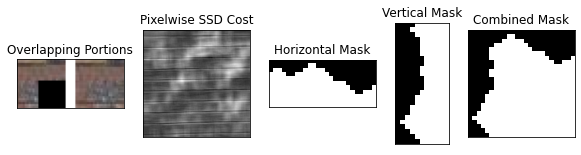

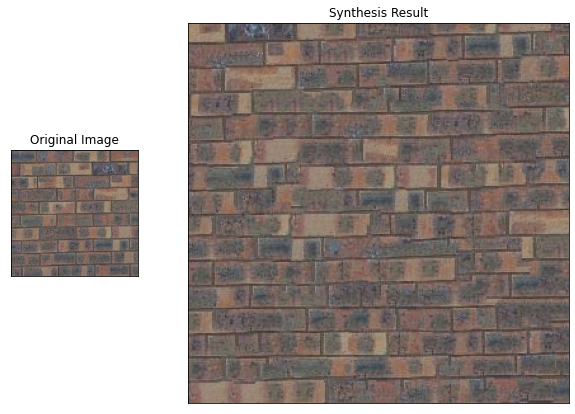

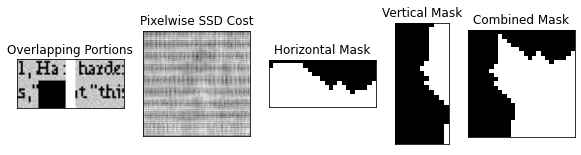

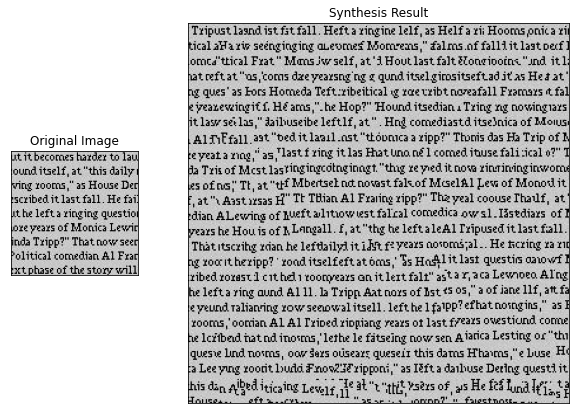

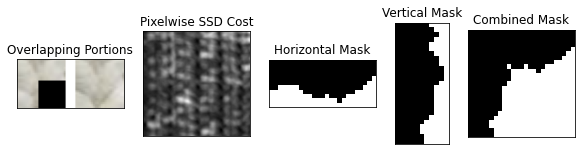

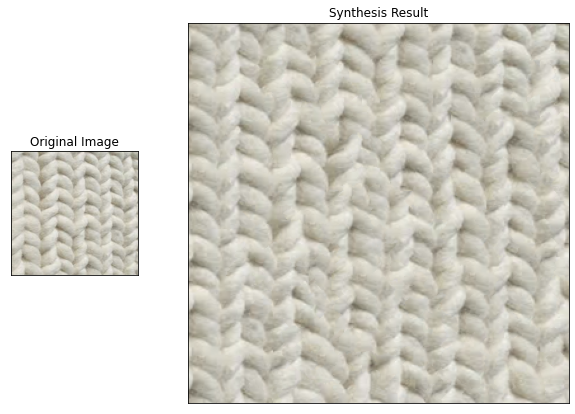

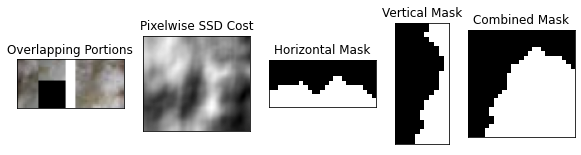

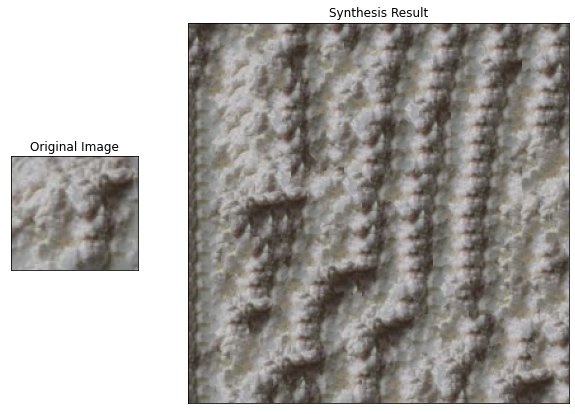

In [34]:
imgs = ['bricks_small.jpg', 'text_small.jpg', 'texture.png', 'white_small.jpg']

for img_name in imgs:
    sample_img_fn = 'samples/{}'.format(img_name)
    sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)

    out_size = 300
    patch_size = 25
    overlap = 11
    tol = 5
    res = quilt_cut(sample_img, out_size, patch_size, overlap, tol, random_first_patch=True, flag=True)
    if res is not None:
        fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 3]}, figsize=(10, 10))
        axes[0].imshow(sample_img)
        axes[0].set_title('Original Image'), axes[0].set_xticks([]), axes[0].set_yticks([])
        axes[1].imshow(res)
        axes[1].set_title('Synthesis Result'), axes[1].set_xticks([]), axes[1].set_yticks([])
        plt.show()

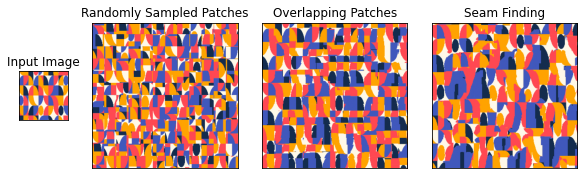

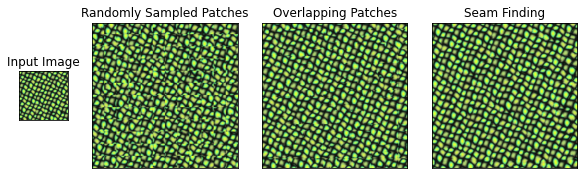

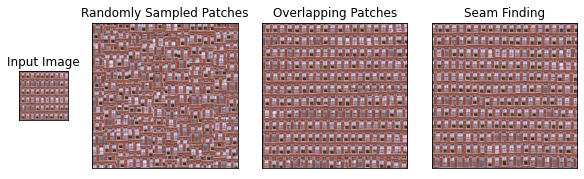

In [56]:
imgs = ['pattern2.jpg', 'pattern1.png', 'pattern3.png']

for img_name in imgs:
    sample_img_fn = 'samples/{}'.format(img_name)
    sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
    sample_img = cv2.resize(sample_img, (150, 150))

    out_size = 300
    patch_size = 25
    overlap = 11
    tol = 5
    res_random = quilt_random(sample_img, out_size, patch_size)
    res_simple = quilt_simple(sample_img, out_size, patch_size, overlap, tol)
    res_cut = quilt_cut(sample_img, out_size, patch_size, overlap, tol, random_first_patch=True)
    if res is not None:
        fig, axes = plt.subplots(1, 4, gridspec_kw={'width_ratios': [1, 3, 3, 3]}, figsize=(10, 10))
        axes[0].imshow(sample_img)
        axes[0].set_title('Input Image'), axes[0].set_xticks([]), axes[0].set_yticks([])
        axes[1].imshow(res_random)
        axes[1].set_title('Randomly Sampled Patches'), axes[1].set_xticks([]), axes[1].set_yticks([])
        axes[2].imshow(res_simple)
        axes[2].set_title('Overlapping Patches'), axes[2].set_xticks([]), axes[2].set_yticks([])
        axes[3].imshow(res_cut)
        axes[3].set_title('Seam Finding'), axes[3].set_xticks([]), axes[3].set_yticks([])
        plt.show()

### part IV: Texture Transfer (30 pts)

In [11]:
def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patch_size from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """
    
    # normalize the `sample` image
    sample = sample / 255.
    guidance_im = guidance_im / 255.

    # create `out` as a placeholder for the output
    out_size_x, out_size_y, _ = guidance_im.shape
    out = np.zeros(guidance_im.shape)

    # get correspondence maps
    texture_cm = cv2.cvtColor(cv2.GaussianBlur(sample, (25, 25), 5).astype('float32'), cv2.COLOR_RGB2GRAY)
    texture_cm = np.stack([texture_cm] * 3, axis=-1)
    guidance_cm = cv2.cvtColor(cv2.GaussianBlur(guidance_im, (25, 25), 5).astype('float32'), cv2.COLOR_RGB2GRAY)
    guidance_cm = np.stack([guidance_cm] * 3, axis=-1)

    for i in range((out_size_x - patch_size) // (patch_size - overlap) + 2):
        for j in range((out_size_y - patch_size) // (patch_size - overlap) + 2):
            # fill in the top-left of `out` with a random patch from `sample`
            if i == 0 and j == 0:
                # select the first patch in the out using the `guidance_im`
                guidance_template = guidance_cm[(i * patch_size - i * overlap) : ((i + 1) * patch_size - i * overlap), 
                                                (j * patch_size - j * overlap) : ((j + 1) * patch_size - j * overlap), 
                                                :]
                ssd_cost = ssd_patch(guidance_template, np.ones(guidance_template.shape), texture_cm)
                patch = choose_sample(sample, ssd_cost, tol, patch_size)

                # place the patch in `out`
                out[0 : patch_size, 0 : patch_size, :] = patch
            
            # find a good patch for overlapping cases
            else:
                # get the texture template from `out`
                texture_template = out[(i * patch_size - i * overlap) : ((i + 1) * patch_size - i * overlap), 
                                       (j * patch_size - j * overlap) : ((j + 1) * patch_size - j * overlap), 
                                       :]
                # create the mask
                mask = np.zeros(texture_template.shape)
                if i != 0: mask[0 : overlap, :, :] = 1.
                if j != 0: mask[:, 0 : overlap, :] = 1.
                
                # find the `ssd_overlap_cost` patch
                ssd_overlap_cost = ssd_patch(texture_template, mask, sample)

                # get the guidance template from `guidance_im`
                guidance_template = guidance_cm[(i * patch_size - i * overlap) : ((i + 1) * patch_size - i * overlap), 
                                                (j * patch_size - j * overlap) : ((j + 1) * patch_size - j * overlap), 
                                                :]
                # find the `ssd_transfer_cost` patch
                ssd_transfer_cost = ssd_patch(guidance_template, np.ones(guidance_template.shape), texture_cm)

                # find the total ssd cost 
                ssd_cost = alpha * ssd_overlap_cost + (1 - alpha) * ssd_transfer_cost

                # choose a patch with low cost
                patch = choose_sample(sample, ssd_cost, tol, patch_size)

                # find the minimum error boundary cut
                boundary_cut = np.ones((min(patch_size, out.shape[0] - (i * patch_size - i * overlap)),
                                        min(patch_size, out.shape[1] - (j * patch_size - j * overlap)), 
                                        3))
                horizontal_err = np.ones((overlap,
                                          min(patch_size, out.shape[1] - (j * patch_size - j * overlap)), 
                                          3))
                vertical_err = np.ones((overlap,
                                        min(patch_size, out.shape[0] - (i * patch_size - i * overlap)), 
                                        3))
                if i != 0: 
                    horizontal_template = texture_template[0 : overlap, 
                                                           0 : min(patch_size, out.shape[1] - (j * patch_size - j * overlap)), 
                                                           :]
                    horizontal_patch = patch[0 : overlap, 
                                             0 : min(patch_size, out.shape[1] - (j * patch_size - j * overlap)), 
                                             :]
                    horizontal_err = (horizontal_template - horizontal_patch) ** 2
                    horizontal_err = horizontal_err[:, :, 0] + horizontal_err[:, :, 1] + horizontal_err[:, :, 2]
                    horizontal_cut = customized_cut(horizontal_err)
                    horizontal_cut = np.stack([horizontal_cut] * 3, axis=-1)
                    boundary_cut[0 : overlap, 
                                 0 : min(patch_size, out.shape[1] - (j * patch_size - j * overlap)), 
                                 :] = horizontal_cut
                    
                if j != 0:
                    vertical_template = texture_template[0 : min(patch_size, out.shape[0] - (i * patch_size - i * overlap)), 
                                                         0 : overlap, 
                                                         :]
                    vertical_patch = patch[0 : min(patch_size, out.shape[0] - (i * patch_size - i * overlap)),
                                           0 : overlap,
                                           :]
                    vertical_err = (vertical_template - vertical_patch) ** 2
                    vertical_err = vertical_err[:, :, 0] + vertical_err[:, :, 1] + vertical_err[:, :, 2]
                    vertical_cut = customized_cut(vertical_err.transpose()).transpose()
                    vertical_cut = np.stack([vertical_cut] * 3, axis=-1)
                    boundary_cut[0 : min(patch_size, out.shape[0] - (i * patch_size - i * overlap)),
                                 0 : overlap,
                                 :] = np.logical_and(boundary_cut[:, 0 : overlap, :], vertical_cut)
                

                # create the patch using `boundary_cut`
                patch = patch[0 : min(patch_size, out.shape[0] - (i * patch_size - i * overlap)),
                              0 : min(patch_size, out.shape[1] - (j * patch_size - j * overlap)),
                              :]
                boundary_cut = boundary_cut[0 : min(patch_size, out.shape[0] - (i * patch_size - i * overlap)),
                                            0 : min(patch_size, out.shape[1] - (j * patch_size - j * overlap)),
                                            :]
                patch = boundary_cut * patch + (1 - boundary_cut) * texture_template

                # place the patch in `out`
                out[(i * patch_size - i * overlap) : ((i + 1) * patch_size - i * overlap), 
                    (j * patch_size - j * overlap) : ((j + 1) * patch_size - j * overlap), 
                    :] = patch
    
    return out

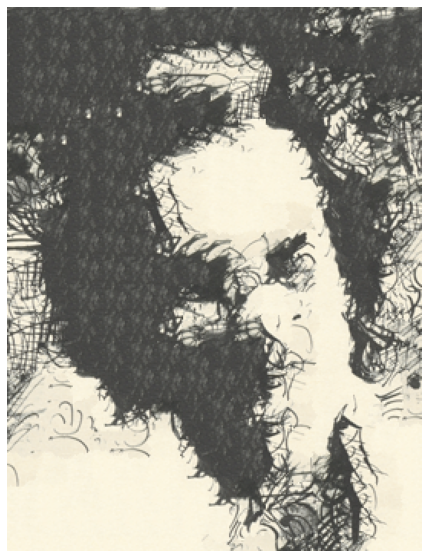

In [12]:
# load/process appropriate input texture and guidance images
texture_img_fn = 'samples/sketch.tiff' 
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)
guidance_img_fn = 'samples/feynman.tiff'
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)

patch_size = 25
overlap = 7
tol = 5
alpha = 0.4
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure(figsize=(10, 10))
plt.imshow(res)
plt.axis('off')
plt.show()

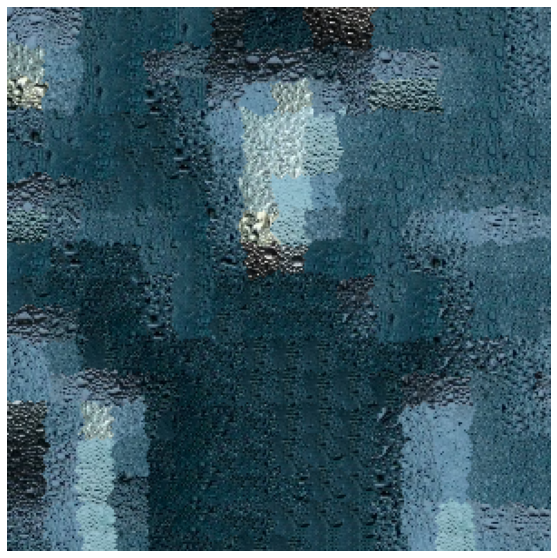

In [72]:
# load/process appropriate input texture and guidance images
texture_img_fn = 'samples/glass.jpg' 
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)
guidance_img_fn = 'samples/savya.jpg'
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)

patch_size = 25
overlap = 7
tol = 5
alpha = 0.4
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure(figsize=(10, 10))
plt.imshow(res)
plt.axis('off')
plt.show()

### Bells & Whistles

(10 pts) Create and use your own version of cut.m. To get these points, you should create your own implementation without basing it directly on the provided function (you're on the honor code for this one). 

You can simply copy your customized_cut(bndcost) into the box below so that it is easier for us to grade

In [73]:
def customized_cut(bndcost):
    class Node:
        ''' A class to represent the pixel nodes in the error patch '''
        def __init__(self, x, y, cost, parent=None):
            self.x = x
            self.y = y
            self.cost = cost
            self.parent = parent

        def __repr__(self):
            return str(self.cost)
        
        def __lt__(self, other):
            return self.cost < other.cost
    
    # initialize priority queue
    q = []
    heapq.heapify(q)
    resolved = np.zeros(bndcost.shape)
    for i in range(bndcost.shape[0]):
        node = Node(i, 0, bndcost[i][0], None)
        heapq.heappush(q, node)
    
    # find the minimum cut path
    while True:
        # resolve the node at the top of `q`
        node = heapq.heappop(q)
        resolved[node.x][node.y] = True

        # check if the resolved node is an end node for the path
        if node.y == bndcost.shape[1] - 1:
            path_itr = node
            break

        # explore the neighbors of `node`
        nbrs = [Node(node.x, node.y + 1, node.cost + bndcost[node.x][node.y + 1], node)]
        if node.x - 1 >= 0: nbrs.append(Node(node.x - 1,
                                             node.y + 1,
                                             node.cost + bndcost[node.x - 1][node.y + 1],
                                             node))
        if node.x + 1 < bndcost.shape[0]: nbrs.append(Node(node.x + 1,
                                                           node.y + 1,
                                                           node.cost + bndcost[node.x + 1][node.y + 1],
                                                           node))
        for nbr in nbrs:
            if not resolved[nbr.x][nbr.y]:
                heapq.heappush(q, nbr)
    
    # mark the minimum cut path
    path = np.ones(bndcost.shape)
    while path_itr.y > 0:
        path[path_itr.x][path_itr.y] = 0.
        path_itr = path_itr.parent
    path[path_itr.x][path_itr.y] = 0.
    
    # create the minimum cut mask
    mask = path
    for j in range(mask.shape[1]):
        i = 0
        while mask[i][j] == 1.: 
            mask[i][j] = 0.
            i += 1
    return mask

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

In [74]:
def texture_transfer_iterative(sample, patch_size, overlap, tol, guidance_im, alpha, iter, prev_im=None):
    """
    Samples square patches of size patch_size from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """
    
    # normalize the `sample` image
    sample = sample / 255.
    guidance_im = guidance_im / 255.

    # create `out` as a placeholder for the output
    out_size_x, out_size_y, _ = guidance_im.shape
    out = np.zeros(guidance_im.shape)

    # get correspondence maps
    texture_cm = cv2.cvtColor(cv2.GaussianBlur(sample, (25, 25), 5).astype('float32'), cv2.COLOR_RGB2GRAY)
    texture_cm = np.stack([texture_cm] * 3, axis=-1)
    guidance_cm = cv2.cvtColor(cv2.GaussianBlur(guidance_im, (25, 25), 5).astype('float32'), cv2.COLOR_RGB2GRAY)
    guidance_cm = np.stack([guidance_cm] * 3, axis=-1)

    for i in range((out_size_x - patch_size) // (patch_size - overlap) + 2):
        for j in range((out_size_y - patch_size) // (patch_size - overlap) + 2):
            # fill in the top-left of `out` with a random patch from `sample`
            if i == 0 and j == 0:
                # select the first patch in the out using the `guidance_im`
                guidance_template = guidance_cm[(i * patch_size - i * overlap) : ((i + 1) * patch_size - i * overlap), 
                                                (j * patch_size - j * overlap) : ((j + 1) * patch_size - j * overlap), 
                                                :]
                ssd_cost = ssd_patch(guidance_template, np.ones(guidance_template.shape), texture_cm)
                patch = choose_sample(sample, ssd_cost, tol, patch_size)

                # place the patch in `out`
                out[0 : patch_size, 0 : patch_size, :] = patch
            
            # find a good patch for overlapping cases
            else:
                # get the texture template from `out`
                texture_template = out[(i * patch_size - i * overlap) : ((i + 1) * patch_size - i * overlap), 
                                       (j * patch_size - j * overlap) : ((j + 1) * patch_size - j * overlap), 
                                       :]
                # create the mask
                mask = np.zeros(texture_template.shape)
                if i != 0: mask[0 : overlap, :, :] = 1.
                if j != 0: mask[:, 0 : overlap, :] = 1.
                
                # find the `ssd_overlap_cost` patch
                ssd_overlap_cost = ssd_patch(texture_template, mask, sample)

                # added constraint for the iterative texture transfer
                if iter != 0:
                    # get texture template from `prev_im`
                    prev_template = prev_im[(i * patch_size - i * overlap) : ((i + 1) * patch_size - i * overlap), 
                                            (j * patch_size - j * overlap) : ((j + 1) * patch_size - j * overlap), 
                                            :]
                    # find the `ssd_prev_cost` patch and add it to the `ssd_overlap_cost`
                    ssd_prev_cost = ssd_patch(prev_template, np.ones(prev_template.shape), sample)
                    ssd_overlap_cost = (ssd_prev_cost + ssd_overlap_cost) / 2

                # get the guidance template from `guidance_im`
                guidance_template = guidance_cm[(i * patch_size - i * overlap) : ((i + 1) * patch_size - i * overlap), 
                                                (j * patch_size - j * overlap) : ((j + 1) * patch_size - j * overlap), 
                                                :]
                # find the `ssd_transfer_cost` patch
                ssd_transfer_cost = ssd_patch(guidance_template, np.ones(guidance_template.shape), texture_cm)

                # find the total ssd cost 
                ssd_cost = alpha * ssd_overlap_cost + (1 - alpha) * ssd_transfer_cost

                # choose a patch with low cost
                patch = choose_sample(sample, ssd_cost, tol, patch_size)

                # find the minimum error boundary cut
                boundary_cut = np.ones((min(patch_size, out.shape[0] - (i * patch_size - i * overlap)),
                                        min(patch_size, out.shape[1] - (j * patch_size - j * overlap)), 
                                        3))
                horizontal_err = np.ones((overlap,
                                          min(patch_size, out.shape[1] - (j * patch_size - j * overlap)), 
                                          3))
                vertical_err = np.ones((overlap,
                                        min(patch_size, out.shape[0] - (i * patch_size - i * overlap)), 
                                        3))
                if i != 0: 
                    horizontal_template = texture_template[0 : overlap, 
                                                           0 : min(patch_size, out.shape[1] - (j * patch_size - j * overlap)), 
                                                           :]
                    horizontal_patch = patch[0 : overlap, 
                                             0 : min(patch_size, out.shape[1] - (j * patch_size - j * overlap)), 
                                             :]
                    horizontal_err = (horizontal_template - horizontal_patch) ** 2
                    horizontal_err = horizontal_err[:, :, 0] + horizontal_err[:, :, 1] + horizontal_err[:, :, 2]
                    horizontal_cut = customized_cut(horizontal_err)
                    horizontal_cut = np.stack([horizontal_cut] * 3, axis=-1)
                    boundary_cut[0 : overlap, 
                                 0 : min(patch_size, out.shape[1] - (j * patch_size - j * overlap)), 
                                 :] = horizontal_cut
                    
                if j != 0:
                    vertical_template = texture_template[0 : min(patch_size, out.shape[0] - (i * patch_size - i * overlap)), 
                                                         0 : overlap, 
                                                         :]
                    vertical_patch = patch[0 : min(patch_size, out.shape[0] - (i * patch_size - i * overlap)),
                                           0 : overlap,
                                           :]
                    vertical_err = (vertical_template - vertical_patch) ** 2
                    vertical_err = vertical_err[:, :, 0] + vertical_err[:, :, 1] + vertical_err[:, :, 2]
                    vertical_cut = customized_cut(vertical_err.transpose()).transpose()
                    vertical_cut = np.stack([vertical_cut] * 3, axis=-1)
                    boundary_cut[0 : min(patch_size, out.shape[0] - (i * patch_size - i * overlap)),
                                 0 : overlap,
                                 :] = np.logical_and(boundary_cut[:, 0 : overlap, :], vertical_cut)
                

                # create the patch using `boundary_cut`
                patch = patch[0 : min(patch_size, out.shape[0] - (i * patch_size - i * overlap)),
                              0 : min(patch_size, out.shape[1] - (j * patch_size - j * overlap)),
                              :]
                boundary_cut = boundary_cut[0 : min(patch_size, out.shape[0] - (i * patch_size - i * overlap)),
                                            0 : min(patch_size, out.shape[1] - (j * patch_size - j * overlap)),
                                            :]
                patch = boundary_cut * patch + (1 - boundary_cut) * texture_template

                # place the patch in `out`
                out[(i * patch_size - i * overlap) : ((i + 1) * patch_size - i * overlap), 
                    (j * patch_size - j * overlap) : ((j + 1) * patch_size - j * overlap), 
                    :] = patch
    
    return out

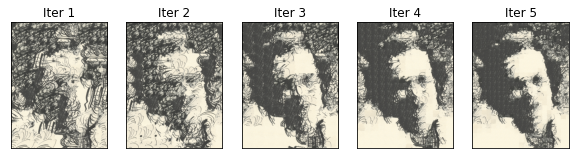

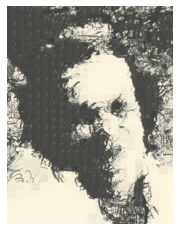

In [90]:
# load/process appropriate input texture and guidance images
texture_img_fn = 'samples/sketch.tiff' 
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)
guidance_img_fn = 'samples/feynman.tiff'
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)

n_iters = 5
patch_size = 75
overlap = 15
tol = 5
iter_res = None

fig, axes = plt.subplots(1, n_iters, figsize=(10, 10))
for iter in range(n_iters):
    iter_res = texture_transfer_iterative(texture_img, patch_size, overlap, tol, guidance_img, alpha, iter, iter_res)
    patch_size = 2 * patch_size // 3
    overlap = 2 * overlap // 3
    if patch_size % 2 == 0: patch_size += 1
    alpha = 0.8 * iter / (n_iters - 1) + 0.1
    axes[iter].imshow(iter_res)
    axes[iter].set_title('Iter {}'.format(iter + 1)), axes[iter].set_xticks([]), axes[iter].set_yticks([])
plt.show()

plt.imshow(iter_res)
plt.axis('off')
plt.show()

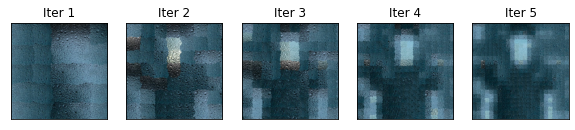

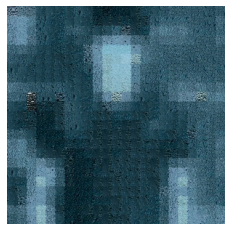

In [91]:
# load/process appropriate input texture and guidance images
texture_img_fn = 'samples/glass.jpg' 
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)
guidance_img_fn = 'samples/savya.jpg'
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)

n_iters = 5
patch_size = 75
overlap = 15
tol = 5
iter_res = None

fig, axes = plt.subplots(1, n_iters, figsize=(10, 10))
for iter in range(n_iters):
    iter_res = texture_transfer_iterative(texture_img, patch_size, overlap, tol, guidance_img, alpha, iter, iter_res)
    patch_size = 2 * patch_size // 3
    overlap = 2 * overlap // 3
    if patch_size % 2 == 0: patch_size += 1
    alpha = 0.8 * iter / (n_iters - 1) + 0.1
    axes[iter].imshow(iter_res)
    axes[iter].set_title('Iter {}'.format(iter + 1)), axes[iter].set_xticks([]), axes[iter].set_yticks([])
plt.show()

plt.imshow(iter_res)
plt.axis('off')
plt.show()

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

In [83]:
def blend(foreground, background):
    # normalize inputs
    # foreground = cv2.cvtColor(foreground.astype('float32'), cv2.COLOR_RGB2GRAY)
    # foreground = np.stack([foreground] * 3, axis=-1)
    background = background / 255.

    # create mask for blending
    mask = np.ones(foreground[:, :, 0].shape)
    pad_x = background.shape[0] - foreground.shape[0]
    pad_y = background.shape[1] - foreground.shape[1]
    mask = np.pad(mask, ((pad_x // 2, pad_x - (pad_x // 2)), (pad_y // 2, pad_y - (pad_y // 2))))
    mask = np.stack([mask] * 3, axis=-1)

    # feathering
    mask = cv2.GaussianBlur(mask, (61, 61), 10)
    foreground = np.pad(foreground, ((pad_x // 2, pad_x - (pad_x // 2)), (pad_y // 2, pad_y - (pad_y // 2)), (0, 0)))
    return mask * foreground + (1 - mask) * background

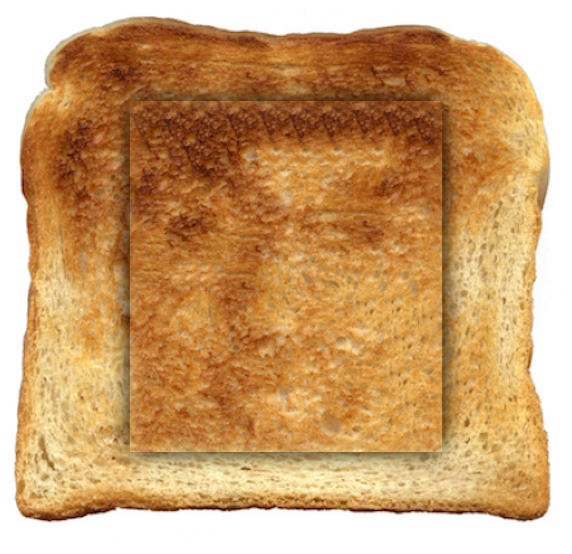

In [88]:
# load/process appropriate input texture and guidance images
toast_img_fn = 'samples/toast.jpg' 
toast_img = cv2.cvtColor(cv2.imread(toast_img_fn), cv2.COLOR_BGR2RGB)
face_img_fn = 'samples/face.png'
face_img = cv2.cvtColor(cv2.imread(face_img_fn), cv2.COLOR_BGR2RGB)

# transfer the texture of the toast onto the face
patch_size = 35
overlap = 7
tol = 3
alpha = 0.5
toasty_face = texture_transfer(toast_img, patch_size, overlap, tol, face_img, alpha)

# blend the images
res = blend(toasty_face, toast_img)

plt.figure(figsize=(10, 10))
plt.imshow(res)
plt.axis('off')
plt.show()